In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
import pandas as pd
import json
import tiktoken

2024-05-05 22:30:37.117685: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using this article: https://medium.com/@maxel333/creating-a-name-generator-with-lstm-9aaa600aeacf as inspiration

In [3]:
# Load and preprocess dataset
def load_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    recipes = pd.DataFrame(data)
    # Tokenize titles
    embedded_titles = recipes['title']
    return embedded_titles

In [7]:
# Define the list of names
file_path = '/Users/carlymiles/Desktop/EECS/DIS-NN/rat-AI-touille/data/processing/stage_1.5/recipes_df.json'
names = load_data(file_path=file_path)

# Tokenize the names at character level
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(names)

# Convert characters to sequences
sequences = tokenizer.texts_to_sequences(names)

In [8]:
# Create input sequences and labels
X = []
y = []
for seq in sequences:
    for i in range(1, len(seq)):
        X.append(seq[:i])
        y.append(seq[i])

# Pad sequences for consistent input shape
max_seq_length = max([len(seq) for seq in X])
X = pad_sequences(X, maxlen=max_seq_length, padding='pre')

# One-hot encode labels
y = tf.keras.utils.to_categorical(y, num_classes=len(tokenizer.word_index) + 1)


In [10]:
len(y)

83278

In [61]:
# Define the LSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 32, input_length=max_seq_length))
model.add(LSTM(64))
model.add(Dense(len(tokenizer.word_index) + 1, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 134, 32)           3208864   
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense_1 (Dense)             (None, 100277)            6518005   
                                                                 
Total params: 9751701 (37.20 MB)
Trainable params: 9751701 (37.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define a custom callback to store training progress
class TrainingProgressCallback(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = []
        self.accuracies = []
        self.losses = []
        
    def on_epoch_end(self, epoch, logs=None):
        accuracy_percentage = logs.get('accuracy') * 100
        loss_percentage = logs.get('loss') * 100
        self.epochs.append(epoch + 1)
        self.accuracies.append(accuracy_percentage)
        self.losses.append(loss_percentage)

# Train the model with the progress callback
progress_callback = TrainingProgressCallback()
model.fit(X, y, epochs=100, verbose=1, callbacks=[progress_callback])

: 

In [8]:
# Display training progress in a table
df = pd.DataFrame({
    'Epoch': progress_callback.epochs,
    'Accuracy': progress_callback.accuracies,
    'Loss': progress_callback.losses
})
print(df)

    Epoch  Accuracy (%)    Loss (%)
0       1     31.704652  237.367415
1       2     44.108889  193.931079
2       3     50.572783  173.970222
3       4     54.801989  159.657371
4       5     57.641876  149.269271
..    ...           ...         ...
95     96     75.363243   82.826316
96     97     75.329620   82.706285
97     98     75.362039   82.640439
98     99     75.365645   82.612884
99    100     75.317609   82.549959

[100 rows x 3 columns]


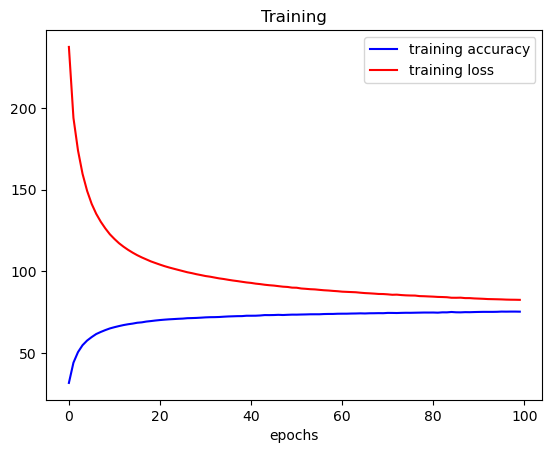

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(progress_callback.accuracies, c='blue', label='training accuracy')
plt.plot(progress_callback.losses, c='red', label='training loss')
plt.title('Training')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [10]:
model.save("model2.keras")

In [6]:
model = load_model('model1.keras')

In [31]:
print(tokenizer.word_index)
print(tokenizer.word_index['z'])

{' ': 1, 'a': 2, 'e': 3, 's': 4, 'i': 5, 't': 6, 'o': 7, 'r': 8, 'l': 9, 'n': 10, 'h': 11, 'd': 12, 'c': 13, 'm': 14, 'u': 15, 'p': 16, 'b': 17, 'w': 18, 'g': 19, 'f': 20, 'k': 21, '-': 22, 'y': 23, 'v': 24, ',': 25, 'z': 26, "'": 27, '(': 28, ')': 29, 'j': 30, '&': 31, ':': 32, 'q': 33, 'x': 34, 'é': 35, 'ç': 36, '’': 37, '"': 38, '/': 39, 'è': 40, 'ï': 41, 'ñ': 42, '2': 43, '1': 44, '–': 45, 'à': 46, 'â': 47, '5': 48, '.': 49, 'ù': 50, 'î': 51, '“': 52, '”': 53, '0': 54, '#': 55, '9': 56, '?': 57, '®': 58, '!': 59, '‘': 60, 'ã': 61, '§': 62, '3': 63, 'ó': 64, 'í': 65, '4': 66, '»': 67, '—': 68, 'ü': 69, '+': 70}
26


In [49]:
def get_key_from_value(d, val):
    keys = [k for k, v in d.items() if v == val]
    if keys:
        return keys[0]
    return None

# Function to generate a new name
def generate_name(model, tokenizer, max_seq_length, seed_text = ''):
    generated_text = seed_text
    predicted_id = -1
    max_probability = 1
    
    while max_probability > 1e-10 and len(generated_text) <= 71:
        sequence = tokenizer.texts_to_sequences(texts=[generated_text])[0]
        # print(sequence)
        sequence = pad_sequences([sequence], maxlen=max_seq_length, padding='pre')
        
        predicted_probabilities = model.predict(sequence)[0]
        predicted_id = np.argmax(predicted_probabilities)
        max_probability = np.max(predicted_probabilities)
        generated_text += str(get_key_from_value(tokenizer.word_index, predicted_id))
        
    return generated_text

In [47]:
import string
name_list = []
for char in string.ascii_lowercase:
    name_list = np.append(name_list, generate_name(model, tokenizer=tokenizer, max_seq_length=134, seed_text = char))


[2]
1/1 [==============================] - 0s 33ms/step
[2, 10]
1/1 [==============================] - 0s 24ms/step
[2, 10, 13]
1/1 [==============================] - 0s 26ms/step
[2, 10, 13, 11]
1/1 [==============================] - 0s 24ms/step
[2, 10, 13, 11, 7]
1/1 [==============================] - 0s 24ms/step
[2, 10, 13, 11, 7, 24]
1/1 [==============================] - 0s 64ms/step
[2, 10, 13, 11, 7, 24, 23]
1/1 [==============================] - 0s 25ms/step
[2, 10, 13, 11, 7, 24, 23, 1]
1/1 [==============================] - 0s 23ms/step
[2, 10, 13, 11, 7, 24, 23, 1, 20]
1/1 [==============================] - 0s 24ms/step
[2, 10, 13, 11, 7, 24, 23, 1, 20, 5]
1/1 [==============================] - 0s 24ms/step
[2, 10, 13, 11, 7, 24, 23, 1, 20, 5, 4]
1/1 [==============================] - 0s 25ms/step
[2, 10, 13, 11, 7, 24, 23, 1, 20, 5, 4, 11]
1/1 [==============================] - 0s 24ms/step
[2, 10, 13, 11, 7, 24, 23, 1, 20, 5, 4, 11, 1]
1/1 [==============================

In [50]:
empty = ''
for name in name_list:
    new = empty.join(name)
    print(new)

anchovy fish fillets with chile sauce and chile sauce and chile sauce an
baked fish with chill sauce and chips and spicy tomato sauce and chile s
crispy baked fish with chile sauce and chile sauce and chile sauce and c
dill cod fillets with chile sauce and chile sauce and chile sauce and ch
easy baked fish with chile sauce and chile sauce and chile sauce and chi
fish tacos with crumb sauce and chile sauce and chile sauce and chile sa
grilled salmon with sweet chilean sauce and chile sauce and chile sauce 
halibut with chile sauce and chile sauce and chile sauce and chile sauce
indian-spiced salmon with sweet chilean sauce and chile sauce and chile 
japanese salad with carrots and salsa verder and spicy tomato sauce and 
kedgeree roasted salmon with sweet chilean sauce and chile sauce and chi
lemon steamed salmon with sweet chile sauce and chile sauce and chile sa
mahi mahi with chill sauce and chips and spicy tomato sauce and chile sa
nornarassanata fish tacos with crumb sauce and chil